# Het voorspellen of iemand oud is of niet 

## Business Understanding: 
Van volwassen beroemdheden is het vaak lastig te zeggen hoe oud ze zijn. Nu gaan we kijken of we een neuraal netwerk kunnen bouwen wat dit beter kan schatten dan wij. We nemens als grens de compleet arbitraire waarde van 42 jaar. Iedereen tussen de 21 en 42 noemen we 'not old' en iedereen boven deze grens definieren we als 'old' 

We gebruiken hiervoor de IMDB faces database met daarin meer dan 460.000 gezichten van een dikke 20.000 beroemdheden afkomstig van IMDB (zie https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ voor uitleg en details) en hierbij de IMDB informatie over o.a. leeftijd en geslacht. We downloaden hier de de cropped IMDB dataset( https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar). De metadata wordt in .mat (matlab) bestand meegeleverd. 

- We beperken ons tot volwassen beroemdheden. <u>Iedereen onder de 21 jaar mag je overslaan.</u>
- Er zitten nogal wat foto's met meerdere gezichten of geen gezicht op. <u>Deze mag je eruit filteren</u>
- We verwachten niet alleen de code maar (in het notebook) ook een <u>uitleg</u> van waarom je dingen hebt gedaan. 
- I.v.m. performance issues gebruiken we na opschoning alleen de <u>1e 50.000</u> records als data
- Gebruik <u>20% van je data als testset, gebruik 42 als random state</u>
- Eindig met de mogelijkheid om een jpg van bijv. jezelf in te lezen en d.m.v. het getrainde netwerk te bepalen of diegene wel of niet oud is.
`

## 1. Data Understanding: 

We zullen beginnen met de data inlezen en kijken naar welke rows en columns er zijn, hoe ziet de data eruit zit er foutieve data in etc. 

## 1.2 Inladen van de data 

Hier openen we het tar bestand en pakken we alles uit in de map imdb_crop vervolgens laden we de imdb.mat file in


In [1]:
# Check if TensorFlow can access a GPU
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')

if gpus:
  for gpu in gpus:
    print(f"Device: {gpu}")
  else:
    print("No GPU devices found.")


2024-09-19 12:57:22.880797: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-19 12:57:23.055375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 12:57:23.114484: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 12:57:23.129778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 12:57:23.239679: I tensorflow/core/platform/cpu_feature_guar

Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
No GPU devices found.


I0000 00:00:1726743445.900274    2579 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726743446.010640    2579 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726743446.010787    2579 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [2]:
import tarfile
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Deze code hieronder moet alleen gedaan worden wanneer tar file nog niet ingeladen is:

# tar = tarfile.open("imdb_crop.tar")
# tar.extractall()
# tar.close()

mat = scipy.io.loadmat('imdb_crop/imdb.mat')

In [3]:
#Lees de metadata in, bestudeer deze en maak voor iedere relevante variabele een aparte list aan
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Jan 17 11:30:27 2016',
 '__version__': '1.0',
 '__globals__': [],
 'imdb': array([[(array([[693726, 693726, 693726, ..., 726831, 726831, 726831]], dtype=int32), array([[1968, 1970, 1968, ..., 2011, 2011, 2011]], dtype=uint16), array([[array(['01/nm0000001_rm124825600_1899-5-10_1968.jpg'], dtype='<U43'),
                 array(['01/nm0000001_rm3343756032_1899-5-10_1970.jpg'], dtype='<U44'),
                 array(['01/nm0000001_rm577153792_1899-5-10_1968.jpg'], dtype='<U43'),
                 ...,
                 array(['08/nm3994408_rm926592512_1989-12-29_2011.jpg'], dtype='<U44'),
                 array(['08/nm3994408_rm943369728_1989-12-29_2011.jpg'], dtype='<U44'),
                 array(['08/nm3994408_rm976924160_1989-12-29_2011.jpg'], dtype='<U44')]],
               dtype=object), array([[1., 1., 1., ..., 0., 0., 0.]]), array([[array(['Fred Astaire'], dtype='<U12'),
                 array(['Fred Astaire'], d

## 1.3 Wat zien we bij het inladen van de data? 

We kunnen hier een python woordenboek zien dat is ingeladen door een .mat bestand hier kunnen we een aantal details zien zoals: 

__header__ = Dit bevat de metadata zoals het formaat van het bestand en het platform waar het bestand is gemaakt 
__version__ = Versie van matlab formaat 
__globals__ Hier staan globale variabelen, maar deze zijn hier niet van toepassing 

Verder kunnen we zien dat de meeste variabelen van type Object zijn 

En dan het belangrijkste deel is de 'imdb' dit is een array. Elk rij in deze array is een tuple met de volgende elementen:

- dob: Geboortedatum van de celebrity
- photo_taken: Jaar waarin de foto is genomen 
- full_path: Het pad naar het afbeeldingsbestand
- gender: Geslacht van de celebrity, met 0 voor vrouw en 1 voor man.
- name: Naam van de celebrity (Object array).
- face_location: Locatie van het gezicht in de afbeelding, weergegeven als een array van coördinaten.
- face_score: Score van gezichtsdetectie hoe hoger de score, hoe beter de detectie.
- second_face_score: Score van een tweede gezichen, nuttig voor het negeren van afbeeldingen met meerdere gezichten.
- celeb_names: Namen van alle celebrities in de dataset
- celeb_id: ID van de celebrity

## 1.4 Aparte list maken van alle variabelen 
Om makkelijk filtering toe te passen en te werken met data moeten we eerst zorgen dat we voor alle variabelen een aparte list maken. 

Om bij de verschillende variabelen te komen in de lijst moeten we over de geneste array / matrix heen dit kunnen we doen door **imdb['key'][0,0]** te doen dit selecteert op de eerste rij de eerste kolom van die array met die key naam 

vervolgens kunnen we deze multidimensionele array om zetten naar een eendimensionele array, dit zal ervoor zorgen dat we makkelijker met de data kunnen werken 

In [4]:
imdb = mat['imdb']

dob = imdb['dob'][0, 0].flatten()
photo_taken = imdb['photo_taken'][0, 0].flatten()
full_path = imdb['full_path'][0, 0].flatten()
gender = imdb['gender'][0, 0].flatten()
name = imdb['name'][0, 0].flatten()
face_location = imdb['face_location'][0, 0].flatten()
face_score = imdb['face_score'][0, 0].flatten()
second_face_score = imdb['second_face_score'][0, 0].flatten()
celeb_names = imdb['celeb_names'][0, 0].flatten()
celeb_id = imdb['celeb_id'][0, 0].flatten()



In [5]:
unique_celeb_ids = pd.Series(celeb_id).nunique()
print(unique_celeb_ids)

20284


## 1.5 Wat zien we voor data in de nieuwe lijsten? 

We zullen een tijdelijke example list maken zodat we niet voor elke variabele een aparte print hoeven te doen dan kunnen we gewoon lopen over de lijst en kijken naar bijv length hoeveel nan values er zijn etc 

In [6]:
lists = {
    'dob': dob,
    'photo_taken': photo_taken,
    'full_path': full_path,
    'gender': gender,
    'name': name,
    'face_location': face_location,
    'face_score': face_score,
    'second_face_score': second_face_score,
    'celeb_names': celeb_names,
    'celeb_id': celeb_id
}

info_list = []

for key, value in lists.items():
    info_list.append(f"\nAantal records in {key}: {len(value)}")

print("\n".join(info_list))



Aantal records in dob: 460723

Aantal records in photo_taken: 460723

Aantal records in full_path: 460723

Aantal records in gender: 460723

Aantal records in name: 460723

Aantal records in face_location: 460723

Aantal records in face_score: 460723

Aantal records in second_face_score: 460723

Aantal records in celeb_names: 20284

Aantal records in celeb_id: 460723


We kunnen zien dat er intotaal 460723 records zijn. Verder is het belangrijk om te weten dat er 20 duizend hiervan celebs zijn. 

Wat apart is om te zien is dat er 20 duizend celebirty namen zijn en 460 duizend celeb_ids

We kunnen zien dat er 1 record is met een face_location we zullen hier naar kijken, want waarschijnlijk kan deze uit de dataset gehaald worden, aangezien we een dataset hebben nu van alleen gecropped images van alleen het gezicht 

## 1.6 Plot de image waarbij er een face_location aanwezig is 

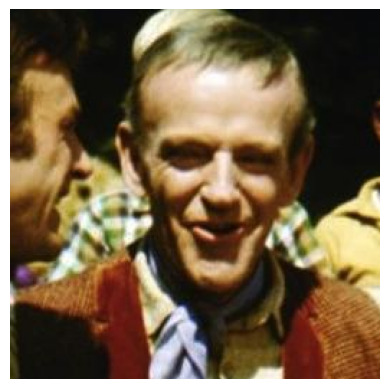

In [7]:
index_with_face_location = np.where([len(loc) > 0 for loc in face_location])[0][0]

image_path = full_path[index_with_face_location][0]

img = mpimg.imread(f'imdb_crop/{image_path}')
plt.imshow(img)
plt.axis('off')
plt.show()

## 1.7 second_face_score 

In de documentatie staat dat een second_face_Score van Nan aantoont dat er dus niemand erbij staat in de foto deze zouden we dus kunnen gebruiken de rest moeten we wegfilteren we zullen nu checken hoeveel dit er zijn

In [8]:
import numpy as np

nan_count = np.isnan(second_face_score).sum()
print(f"Aantal NaN values in second_face_score: {nan_count}")

Aantal NaN values in second_face_score: 246926


Het aantal nan values dat we zien is 246 duizend dit betekent dat deze meegenomen kunnen worden, maar aan het begin van de opdracht is beschreven dat we maar 50 duizend personen zullen mee nemen voor het trainen van ons model 

## 1.8 Dob

We kunnen zien dat dob niet een fijne format geeft van date of birth wat we zouden willen. Dit komt omdat het een Matlab-serial date nummer is, deze worden gemeten vanaf 0000-01-01. Dit moet omgezet worden naar een gewoon datumformaat voordat je de leeftijden kunt berekenen.

Door alles te delen door 365 zullen we de juiste jaren krijgen dit kunnen we vervolgens afronden 



In [9]:
dob

array([693726, 693726, 693726, ..., 726831, 726831, 726831], dtype=int32)

In [10]:
count_693726 = np.sum(dob == 693726)
print(f"Aantal keer dat 693726 voorkomt in dob: {count_693726}")

Aantal keer dat 693726 voorkomt in dob: 5


```markdown
## 1.8 Toon afbeeldingen van mensen met dob 693726

We zullen nu de afbeeldingen tonen van de 5 mensen die de geboortedatum 693726 hebben.


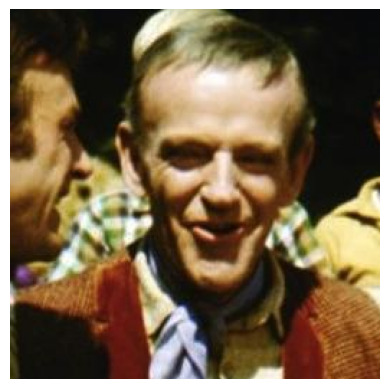

Photo taken in: 1968


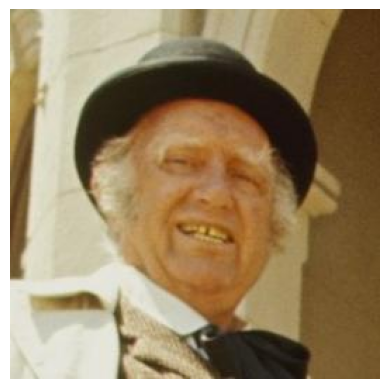

Photo taken in: 1970


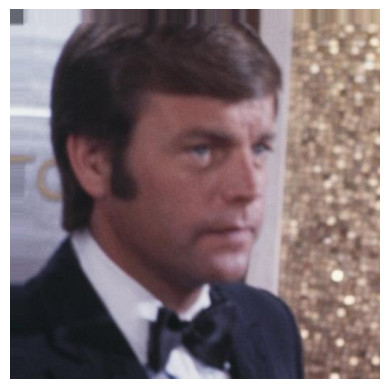

Photo taken in: 1968


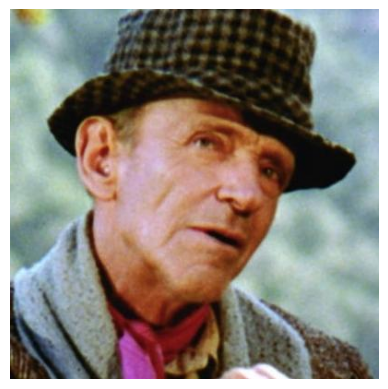

Photo taken in: 1968


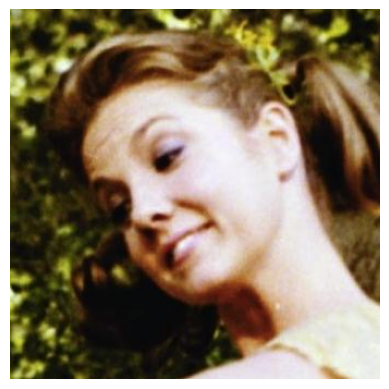

Photo taken in: 1968


In [11]:
# Vind de indices van de mensen met dob 693726
indices_with_dob_693726 = np.where(dob == 693726)[0][:5]

# Toon de afbeeldingen van deze mensen
for index in indices_with_dob_693726:
  image_path = full_path[index][0]
  img = mpimg.imread(f'imdb_crop/{image_path}')
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  print(f"Photo taken in: {photo_taken[index]}")

We zien 5 mensen met dezelfde values, dit lijkt een soort Base te zijn van 1900 als standaard jaar, daarbij zien we dat 4 van de 5 de foto toevallig ook in 1968 zijn geschoten

Hieronder zullen nu delen door 365 dagen om de juiste jaren van de geboorte van de mensen te vinden 

In [12]:
dob_years = dob / 365
dob_years = np.floor(dob_years)
print(dob_years)

[1900. 1900. 1900. ... 1991. 1991. 1991.]


In [13]:
print(np.array(face_location).shape)

(460723,)


## 1.9 Is de dataset gelijk met gender? 

In [14]:
count_1 = np.sum(gender == 1)

# Tellen van 0s
count_0 = np.sum(gender == 0)

print(f"Count of 1: {count_1}")
print(f"Count of 0: {count_0}")

Count of 1: 263214
Count of 0: 189047


We zien dat er een stuk meer mannen zijn dan vrouwen, dit zou invloed kunnen hebben op ons uiteindelijke model 

# 2. Data preparation: 

We zullen hier beginnen met Data Preperation we hebben een aantal belangrijke punten die we moeten meenemen en tijdens het kijken naar resultaten zullen we zien of we nog meer data prep nodig hebben 

- We beperken ons tot volwassen beroemdheden. <u>Iedereen onder de 21 jaar mag je overslaan.</u>
- Er zitten nogal wat foto's met meerdere gezichten of geen gezicht op. <u>Deze mag je eruit filteren</u>
- We verwachten niet alleen de code maar (in het notebook) ook een <u>uitleg</u> van waarom je dingen hebt gedaan. 
- I.v.m. performance issues gebruiken we na opschoning alleen de <u>1e 50.000</u> records als data
- Gebruik <u>20% van je data als testset, gebruik 42 als random state</u>
- Eindig met de mogelijkheid om een jpg van bijv. jezelf in te lezen en d.m.v. het getrainde netwerk te bepalen of diegene wel of niet oud is.


## 2.1 Lijst maken met alle metadata en de juiste leeftijd in jaren 

In [15]:

df = pd.DataFrame({
    'dob': dob_years,
    'photo_taken': photo_taken,
    'full_path': full_path,
    'gender': gender,
    'name': name,
    'face_location': face_location,
    'face_score': face_score,
    'second_face_score': second_face_score,
    'celeb_id': celeb_id
})


df['celeb_names'] = np.nan
celeb_names_dict = dict(zip(celeb_id, celeb_names))

df['celeb_names'] = df['celeb_id'].map(celeb_names_dict)

print(df.head())

      dob  photo_taken                                       full_path  \
0  1900.0         1968   [01/nm0000001_rm124825600_1899-5-10_1968.jpg]   
1  1900.0         1970  [01/nm0000001_rm3343756032_1899-5-10_1970.jpg]   
2  1900.0         1968   [01/nm0000001_rm577153792_1899-5-10_1968.jpg]   
3  1900.0         1968   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]   
4  1900.0         1968   [01/nm0000001_rm980463616_1899-5-10_1968.jpg]   

   gender            name                                      face_location  \
0     1.0  [Fred Astaire]  [[1072.926, 161.838, 1214.7839999999999, 303.6...   
1     1.0  [Fred Astaire]              [[477.184, 100.352, 622.592, 245.76]]   
2     1.0  [Fred Astaire]  [[114.96964308962852, 114.96964308962852, 451....   
3     1.0  [Fred Astaire]  [[622.8855056426588, 424.21750383700805, 844.3...   
4     1.0  [Fred Astaire]  [[1013.8590023603723, 233.8820422075853, 1201....   

   face_score  second_face_score  celeb_id   celeb_names  
0    1.459693  

In [16]:
df

dob  photo_taken                                       full_path  \
0       1900.0         1968   [01/nm0000001_rm124825600_1899-5-10_1968.jpg]   
1       1900.0         1970  [01/nm0000001_rm3343756032_1899-5-10_1970.jpg]   
2       1900.0         1968   [01/nm0000001_rm577153792_1899-5-10_1968.jpg]   
3       1900.0         1968   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]   
4       1900.0         1968   [01/nm0000001_rm980463616_1899-5-10_1968.jpg]   
...        ...          ...                                             ...   
460718  1991.0         2011  [08/nm3994408_rm761245696_1989-12-29_2011.jpg]   
460719  1991.0         2011  [08/nm3994408_rm784182528_1989-12-29_2011.jpg]   
460720  1991.0         2011  [08/nm3994408_rm926592512_1989-12-29_2011.jpg]   
460721  1991.0         2011  [08/nm3994408_rm943369728_1989-12-29_2011.jpg]   
460722  1991.0         2011  [08/nm3994408_rm976924160_1989-12-29_2011.jpg]   

        gender            name  \
0          1.0  [Fred Astaire]   
1          1.0  [Fred Astaire]   
2          1.0  [Fred Astaire]   
3          1.0  [Fred Astaire]   
4          1.0  [Fred Astaire]   
...        ...             ...   
460718     0.0     [Jane Levy]   
460719     0.0     [Jane Levy]   
460720     0.0     [Jane Levy]   
460721     0.0     [Jane Levy]   
460722     0.0     [Jane Levy]   

                                            face_location  face_score  \
0       [[1072.926, 161.838, 1214.7839999999999, 303.6...    1.459693   
1                   [[477.184, 100.352, 622.592, 245.76]]    2.543198   
2       [[114.96964308962852, 114.96964308962852, 451....    3.455579   
3       [[622.8855056426588, 424.21750383700805, 844.3...    1.872117   
4       [[1013.8590023603723, 233.8820422075853, 1201....    1.158766   
...                                                   ...         ...   
460718  [[453.8981431333457, 77.96623712908011, 539.79...    3.845884   
460719                                 [[1, 1, 426, 640]]        -inf   
460720                                 [[1, 1, 453, 640]]        -inf   
460721  [[144.75225471724875, 126.76472287759263, 305....    4.450725   
460722               [[457.524, 41.748, 518.016, 102.24]]    2.133503   

        second_face_score  celeb_id   celeb_names  
0                1.118973      6488  [A Martinez]  
1                1.852008      6488  [A Martinez]  
2                2.985660      6488  [A Martinez]  
3                     NaN      6488  [A Martinez]  
4                     NaN      6488  [A Martinez]  
...                   ...       ...           ...  
460718                NaN      8410           NaN  
460719                NaN      8410           NaN  
460720                NaN      8410           NaN  
460721                NaN      8410           NaN  
460722                NaN      8410           NaN  

[460723 rows x 10 columns]

We zien dat dob nu juist is ingeladen, wel zien we problemen met celeb_id en celeb_names het lijkt erop dat niet de juiste id en celeb_names gekoppeld met elkaar zijn, aangezien celeb_names een grote lijst is met alle namen zou het ergens fout kunnen zijn gegaan. 

Nou maakt het voor deze opdracht niet uit aangezien we de leeftijd van de persoon willen voorspellen en de celeb_id en celeb_names niet perse nodig zijn hiervoor de meest belangrijke variabelen zijn :

  - photo_taken
  - dob
  - full path
  - gender
  - face_score 
  _ second_face_score

dit zijn de enige die echt belangrijk zijn en waar iets gedaan mee moet worden 

In [17]:
df['face_location']

0         [[1072.926, 161.838, 1214.7839999999999, 303.6...
1                     [[477.184, 100.352, 622.592, 245.76]]
2         [[114.96964308962852, 114.96964308962852, 451....
3         [[622.8855056426588, 424.21750383700805, 844.3...
4         [[1013.8590023603723, 233.8820422075853, 1201....
                                ...                        
460718    [[453.8981431333457, 77.96623712908011, 539.79...
460719                                   [[1, 1, 426, 640]]
460720                                   [[1, 1, 453, 640]]
460721    [[144.75225471724875, 126.76472287759263, 305....
460722                 [[457.524, 41.748, 518.016, 102.24]]
Name: face_location, Length: 460723, dtype: object

Wat nog handig is om te begrijpen is hoe de face_location werkt 

wat we hier kunnen zien is dat we verschillende X en Ywaarden hebben deze werken alsvolgt: 

x1: De x-coördinaat van de linkerbovenhoek van de rechthoek.

y1: De y-coördinaat van de linkerbovenhoek van de rechthoek.

x2: De x-coördinaat van de rechteronderhoek van de rechthoek.

y2: De y-coördinaat van de rechteronderhoek van de rechthoek.

## 2.2 Alleen boven de 21 jaar pakken

We gaan nu filteren op iedereen die boven de 21 is hiermee kunnen we zorgen dat ons model uiteindelijke betere voorspellingen zal gaan doen 

In [18]:
df = df[df['photo_taken'] - df['dob'] > 21]

print(f"Aantal records na filtering: {len(df)}")

Aantal records na filtering: 406086


## 2.3 Geen gezichten of meerdere gezichten weg filteren 

In de documentatie van IMDB-Wiki wordt aangegeven dat wanneer iets **inf** heeft dit betekent dat er geen face gevonden is en daardoor toont het de volledige image

De term inf staat voor "oneindigheid", een speciale waarde in Python en andere programmeertalen, die wordt gebruikt wanneer getallen buiten het bereik van reguliere numerieke waarden vallen. In dit geval gebruiken we -inf om aan te geven dat de gezichtsherkenningsscore onbepaald is.

we zullen hieronder 3 verschillende images plotten om te zien hoe afbeeldingen eruit ziet met inf in de dataframe


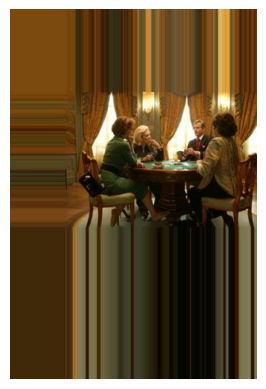

Photo taken in: 2007


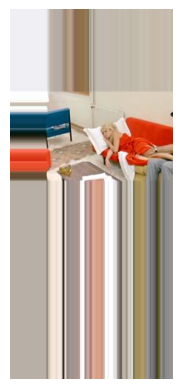

Photo taken in: 1963


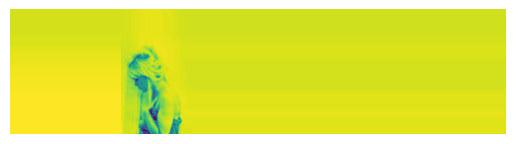

Photo taken in: 1963


In [19]:
indices_with_inf_face_score = df[df['face_score'] == float('-inf')].index[:3]

for index in indices_with_inf_face_score:
    image_path = df.loc[index, 'full_path'][0]
    img = mpimg.imread(f'imdb_crop/{image_path}')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    print(f"Photo taken in: {df.loc[index, 'photo_taken']}")


In [20]:
# Tel het aantal records waar face_score -inf is
aantalInf = df[df['face_score'] == float('-inf')]
count_inf = len(aantalInf)

print(f"Aantal records met -inf in face_score: {count_inf}")

Aantal records met -inf in face_score: 53847


We zien dat er 53 duizend verschillende face_scores zijn van -inf deze zullen we vervolgens verwijderen uit de dataset 

In [21]:
df = df[df['face_score'] != float('-inf')]

print(f"Aantal records na verwijderen van -inf face_scores: {len(df)}")

Aantal records na verwijderen van -inf face_scores: 352239


In [22]:

df = df[df['second_face_score'].isna()]

print(f"Aantal records na filteren op second_face_score NaN: {len(df)}")

Aantal records na filteren op second_face_score NaN: 163398


In [23]:
df

dob  photo_taken                                        full_path  \
3       1900.0         1968    [01/nm0000001_rm946909184_1899-5-10_1968.jpg]   
4       1900.0         1968    [01/nm0000001_rm980463616_1899-5-10_1968.jpg]   
6       1925.0         2004   [02/nm0000002_rm1346607872_1924-9-16_2004.jpg]   
7       1925.0         2004   [02/nm0000002_rm1363385088_1924-9-16_2004.jpg]   
12      1925.0         1974    [02/nm0000002_rm221957120_1924-9-16_1974.jpg]   
...        ...          ...                                              ...   
460682  1991.0         2013  [08/nm3994408_rm2978193408_1989-12-29_2013.jpg]   
460685  1991.0         2013   [08/nm3994408_rm299802624_1989-12-29_2013.jpg]   
460690  1991.0         2013   [08/nm3994408_rm316579840_1989-12-29_2013.jpg]   
460697  1991.0         2014  [08/nm3994408_rm3713712128_1989-12-29_2014.jpg]   
460699  1991.0         2014  [08/nm3994408_rm3926507520_1989-12-29_2014.jpg]   

        gender             name  \
3          1.0   [Fred Astaire]   
4          1.0   [Fred Astaire]   
6          0.0  [Lauren Bacall]   
7          0.0  [Lauren Bacall]   
12         0.0  [Lauren Bacall]   
...        ...              ...   
460682     0.0      [Jane Levy]   
460685     0.0      [Jane Levy]   
460690     0.0      [Jane Levy]   
460697     0.0      [Jane Levy]   
460699     0.0      [Jane Levy]   

                                            face_location  face_score  \
3       [[622.8855056426588, 424.21750383700805, 844.3...    1.872117   
4       [[1013.8590023603723, 233.8820422075853, 1201....    1.158766   
6       [[78.23569406558903, 52.335129377059346, 194.2...    3.479189   
7       [[64.30867103752385, 64.30867103752385, 207.26...    3.870171   
12      [[3173.144692593433, 401.0408365741791, 4059.1...    4.096431   
...                                                   ...         ...   
460682  [[372.77560009473257, 558.1394001420989, 1204....    4.241045   
460685  [[1038.084248201483, 160.08742769175163, 1194....    2.752587   
460690  [[265.4470461529194, 160.08742769175163, 421.4...    1.201887   
460697  [[1508.8323820782705, 840.0002122657057, 2257....    3.953947   
460699  [[472.8605042884207, 199.69200180565082, 583.5...    1.545827   

        second_face_score  celeb_id    celeb_names  
3                     NaN      6488   [A Martinez]  
4                     NaN      6488   [A Martinez]  
6                     NaN     11516  [Aaron Russo]  
7                     NaN     11516  [Aaron Russo]  
12                    NaN     11516  [Aaron Russo]  
...                   ...       ...            ...  
460682                NaN      8410            NaN  
460685                NaN      8410            NaN  
460690                NaN      8410            NaN  
460697                NaN      8410            NaN  
460699                NaN      8410            NaN  

[163398 rows x 10 columns]

De data is nu volledig opgeschoond we zien geen second faces meer in de data en daarbij hebben we nu ook alleen de data gepakt waarbij er een face score is
daarbij zouden we ook nog kunnen kijken naar alleen high face_score want dat betekent dat het beter de face kan zien op de foto, maar voor nu zullen we hier niet mee spelen en laten we gewoon alles staan dat geen -inf heeft 

## 2.4 Alleen de eerste 50 duizend mensen pakken uit dataset 

We pakken ook waar face_score hoger is dan 4 zo zorgen we ervoor dat personen recht in de camera kijken etc, zodat we alleen de accurate foto's gebruiken voor het trainen waar het gezicht goed op staat 

In [24]:
df_first_50k = df.head(50000)

df_first_50k

dob  photo_taken                                       full_path  \
3       1900.0         1968   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]   
4       1900.0         1968   [01/nm0000001_rm980463616_1899-5-10_1968.jpg]   
6       1925.0         2004  [02/nm0000002_rm1346607872_1924-9-16_2004.jpg]   
7       1925.0         2004  [02/nm0000002_rm1363385088_1924-9-16_2004.jpg]   
12      1925.0         1974   [02/nm0000002_rm221957120_1924-9-16_1974.jpg]   
...        ...          ...                                             ...   
127546  1958.0         2014    [58/nm0001758_rm18599424_1957-2-27_2014.jpg]   
127549  1958.0         2007  [58/nm0001758_rm1914079744_1957-2-27_2007.jpg]   
127551  1958.0         2007  [58/nm0001758_rm1997965824_1957-2-27_2007.jpg]   
127553  1958.0         2014  [58/nm0001758_rm2078407168_1957-2-27_2014.jpg]   
127556  1958.0         2014  [58/nm0001758_rm2154087680_1957-2-27_2014.jpg]   

        gender             name  \
3          1.0   [Fred Astaire]   
4          1.0   [Fred Astaire]   
6          0.0  [Lauren Bacall]   
7          0.0  [Lauren Bacall]   
12         0.0  [Lauren Bacall]   
...        ...              ...   
127546     1.0  [Timothy Spall]   
127549     1.0  [Timothy Spall]   
127551     1.0  [Timothy Spall]   
127553     1.0  [Timothy Spall]   
127556     1.0  [Timothy Spall]   

                                            face_location  face_score  \
3       [[622.8855056426588, 424.21750383700805, 844.3...    1.872117   
4       [[1013.8590023603723, 233.8820422075853, 1201....    1.158766   
6       [[78.23569406558903, 52.335129377059346, 194.2...    3.479189   
7       [[64.30867103752385, 64.30867103752385, 207.26...    3.870171   
12      [[3173.144692593433, 401.0408365741791, 4059.1...    4.096431   
...                                                   ...         ...   
127546             [[133.12, 395.264, 1310.72, 1572.864]]    4.570030   
127549            [[591.872, 264.192, 1179.648, 851.968]]    3.871198   
127551  [[660.7575846894997, 585.476489296414, 828.092...    2.378781   
127553  [[679.577858537771, 303.1723815723427, 1355.05...    4.625858   
127556  [[853.7563687616358, 214.97509219040896, 1091....    3.861582   

        second_face_score  celeb_id    celeb_names  
3                     NaN      6488   [A Martinez]  
4                     NaN      6488   [A Martinez]  
6                     NaN     11516  [Aaron Russo]  
7                     NaN     11516  [Aaron Russo]  
12                    NaN     11516  [Aaron Russo]  
...                   ...       ...            ...  
127546                NaN     18973            NaN  
127549                NaN     18973            NaN  
127551                NaN     18973            NaN  
127553                NaN     18973            NaN  
127556                NaN     18973            NaN  

[50000 rows x 10 columns]

## 3 Modeling: 

We gaan nu beginnen met het modelleren we zullen hierbij bezig gaan met tensorflow en voornamelijk CNN's voor het maken van de models, deze is zeer geschikt voor images deep learnen. 

In [25]:

df_first_50k['age'] = df_first_50k['photo_taken'] - df_first_50k['dob']

df_first_50k['age_group'] = df_first_50k['age'].apply(lambda x: 'young' if 21 <= x <= 41 else 'old')

df_first_50k['age_group'] = df_first_50k['age_group'].map({'young': 0, 'old': 1})

features = ['photo_taken', 'gender', 'face_score', 'second_face_score']
target = 'age_group'

X = df_first_50k[features]
y = df_first_50k[target]



/tmp/ipykernel_2579/2825438600.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_50k['age'] = df_first_50k['photo_taken'] - df_first_50k['dob']
/tmp/ipykernel_2579/2825438600.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_50k['age_group'] = df_first_50k['age'].apply(lambda x: 'young' if 21 <= x <= 41 else 'old')
/tmp/ipykernel_2579/2825438600.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

## 3.1 Bouwen van de CNN

In deze sectie bouwen we een Convolutional Neural Network (CNN) om afbeeldingen te classificeren in twee klassen (bijvoorbeeld "young" en "old"). De CNN is speciaal ontworpen voor het verwerken van afbeeldingen en gebruikt een reeks convolutielagen, pooling-lagen, en volledig verbonden lagen om patronen in de beelden te leren herkennen en uiteindelijk een classificatie uit te voeren. Hieronder worden de belangrijkste ontwerpkeuzes en stappen samengevat:

    - We geven een grootte mee van 128 x 128 pixels met Drie kanalen voor RGG we zullen later in het proces de images resizen naar 128,128 omdat de images momenteel veel verschillende grootte hebben. 
    ik heb gekozen voor 128, aangezien dit nog steeds groot is maar niet te groot het neurale netwerk hier goed mee kan werken inplaats van kleiner maken. 

  **Convolutielagen:**

    - Er zijn drie convolutielagen geïmplementeerd, elk gevolgd door een MaxPooling-laag en een Dropout-laag.

    - De eerste laag bevat 64 filters, de tweede laag 128 filters, en de derde laag 256 filters. Ik heb ervoor gekozen om de aantal filters in elke laag te laten toenemen, waarbij ik telkens vermenigvuldig met 2, wat een veelgebruikte aanpak is. Deze waarden kunnen echter naar wens worden aangepast.

    - MaxPooling reduceert de dimensies van de feature maps om de rekenkracht te verminderen en helpt overfitting te voorkomen.
    
    - Dropout wordt gebruikt om willekeurig een deel van de neuronen te negeren tijdens het trainen (25% voor de conv-lagen), wat overfitting tegengaat en de generalisatie van het model verbetert.

  **Fully Connected Layer:**

    Na de convolutielagen wordt de feature map "plat" gemaakt (via Flatten) en door een volledig verbonden laag (Dense) van 1024 neuronen gehaald, gevolgd door Dropout van 50% om overfitting verder te beperken.
    Deze laag leert de samengevoegde features en maakt de uiteindelijke classificatie mogelijk.

  **Outputlaag:**

    De outputlaag bevat 2 neuronen, één voor elke klasse (jong en oud), met een softmax activatiefunctie. Deze activatiefunctie zet de output om in een kansverdeling over de klassen. Softmax is hier gekozen omdat het goed werkt voor categorische classificatieproblemen.

  We zouden er ook voor kunnen kiezen om maar 1 output te hebben waarbij we alleen Age teruggeeft wat de voorspelde age is, maar aangezien dit het doel is van de opdracht zullen we het nu in 2 outputs doen 

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models

def CNN(input_shape=(128, 128, 3)):
    model = models.Sequential()

    # Conv Layer 1
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Conv Layer 2
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Conv Layer 3
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Fully Connected Layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output Layer (Softmax for multiclass classification)
    model.add(layers.Dense(2, activation='softmax'))

    return model


## 3.2 Compileren 

Hier zullen we het model compileren, daarbij zullen we gebruik maken van de optimizer genaamd adam deze is goed voor grote datasets en helpt om efficiënter convergentie te bereiken zonder veel aanpassing van de leersnelheid.
Verder kiezen voor de loss functie categorical_crossentropy aangezien onze output meerdere categorische classificatie is 'jong' en 'oud' 

Accuracy zullen we gebruiken om te kijken hoe accuraat het model is dit is een handig maatstaf daarvoor 

In [27]:
model = CNN()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/home/nick/tf/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1726743450.986847    2579 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726743450.987043    2579 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726743450.987130    2579 cuda_executor.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    51,381,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,754,114 (197.43 MB)

 Trainable params: 51,754,114 (197.43 MB)

 Non-trainable params: 0 (0.00 B)

Hierboven is de summary te zien van het model, dit geeft info zoals hoeveel parameters in elke laag gebruikt zal gaan worden. Je kan zien dat hoe dieper je in de lagen komt hoe meer parameters dit komt omdat wij de lagen een stuk groter hebben gemaakt hoe dieper je komt. 


## 3.3 Aantal jong tegen oud in dataset? 

We kunnen zien dat het aantal young en aantal old ongeveer gelijk is dit is top voor ons model hierdoor zal het model niet snel one sided gaan met het voorspellen 

**Aantal young: 23907**

**Aantal old: 26093**

In [28]:
df_first_50k['age_category'] = df_first_50k['age'].apply(lambda x: 'young' if 21 <= x <= 41 else 'old')

young_count = df_first_50k[df_first_50k['age_category'] == 'young'].shape[0]
print(f"Aantal young: {young_count}")

young_count = df_first_50k[df_first_50k['age_category'] == 'old'].shape[0]
print(f"Aantal old: {young_count}")

Aantal young: 23907
Aantal old: 26093


/tmp/ipykernel_2579/3036485347.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_50k['age_category'] = df_first_50k['age'].apply(lambda x: 'young' if 21 <= x <= 41 else 'old')


In [29]:
df_first_50k

dob  photo_taken                                       full_path  \
3       1900.0         1968   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]   
4       1900.0         1968   [01/nm0000001_rm980463616_1899-5-10_1968.jpg]   
6       1925.0         2004  [02/nm0000002_rm1346607872_1924-9-16_2004.jpg]   
7       1925.0         2004  [02/nm0000002_rm1363385088_1924-9-16_2004.jpg]   
12      1925.0         1974   [02/nm0000002_rm221957120_1924-9-16_1974.jpg]   
...        ...          ...                                             ...   
127546  1958.0         2014    [58/nm0001758_rm18599424_1957-2-27_2014.jpg]   
127549  1958.0         2007  [58/nm0001758_rm1914079744_1957-2-27_2007.jpg]   
127551  1958.0         2007  [58/nm0001758_rm1997965824_1957-2-27_2007.jpg]   
127553  1958.0         2014  [58/nm0001758_rm2078407168_1957-2-27_2014.jpg]   
127556  1958.0         2014  [58/nm0001758_rm2154087680_1957-2-27_2014.jpg]   

        gender             name  \
3          1.0   [Fred Astaire]   
4          1.0   [Fred Astaire]   
6          0.0  [Lauren Bacall]   
7          0.0  [Lauren Bacall]   
12         0.0  [Lauren Bacall]   
...        ...              ...   
127546     1.0  [Timothy Spall]   
127549     1.0  [Timothy Spall]   
127551     1.0  [Timothy Spall]   
127553     1.0  [Timothy Spall]   
127556     1.0  [Timothy Spall]   

                                            face_location  face_score  \
3       [[622.8855056426588, 424.21750383700805, 844.3...    1.872117   
4       [[1013.8590023603723, 233.8820422075853, 1201....    1.158766   
6       [[78.23569406558903, 52.335129377059346, 194.2...    3.479189   
7       [[64.30867103752385, 64.30867103752385, 207.26...    3.870171   
12      [[3173.144692593433, 401.0408365741791, 4059.1...    4.096431   
...                                                   ...         ...   
127546             [[133.12, 395.264, 1310.72, 1572.864]]    4.570030   
127549            [[591.872, 264.192, 1179.648, 851.968]]    3.871198   
127551  [[660.7575846894997, 585.476489296414, 828.092...    2.378781   
127553  [[679.577858537771, 303.1723815723427, 1355.05...    4.625858   
127556  [[853.7563687616358, 214.97509219040896, 1091....    3.861582   

        second_face_score  celeb_id    celeb_names   age  age_group  \
3                     NaN      6488   [A Martinez]  68.0          1   
4                     NaN      6488   [A Martinez]  68.0          1   
6                     NaN     11516  [Aaron Russo]  79.0          1   
7                     NaN     11516  [Aaron Russo]  79.0          1   
12                    NaN     11516  [Aaron Russo]  49.0          1   
...                   ...       ...            ...   ...        ...   
127546                NaN     18973            NaN  56.0          1   
127549                NaN     18973            NaN  49.0          1   
127551                NaN     18973            NaN  49.0          1   
127553                NaN     18973            NaN  56.0          1   
127556                NaN     18973            NaN  56.0          1   

       age_category  
3               old  
4               old  
6               old  
7               old  
12              old  
...             ...  
127546          old  
127549          old  
127551          old  
127553          old  
127556          old  

[50000 rows x 13 columns]

## 3.4 Mappenstructuur voor old en young 

Voor modeltraining is het vaak nodig om afbeeldingen te organiseren in verschillende categorieën of klassen. Hier worden mappen aangemaakt voor twee leeftijdsgroepen: young (jong) en old (oud). Dit maakt het gemakkelijker om de gegevens te beheren en te gebruiken in trainings- en validatiestappen. 

zo kunnen we straks makkelijk onze destination_folder meegeven aan het ImageDataGenerator en deze heeft het dan al gelabeld zodat we dat niet handmatig hoeven te doen voor alle afbeeldingen ook kan je hiermee makkelijk evalueren hierdoor is de correcte labeling voor de image er al

In [30]:
import os
import shutil
import pandas as pd

source_folder = 'imdb_crop'
destination_folder = 'imdb_categorized'
young_folder = os.path.join(destination_folder, 'young')
old_folder = os.path.join(destination_folder, 'old')

# als ze al bestaan gaan we lekker verder
os.makedirs(young_folder, exist_ok=True)
os.makedirs(old_folder, exist_ok=True)

young_count = 0
old_count = 0

for idx, row in df_first_50k.iterrows():
    full_path = row['full_path'][0]
    age = row['age']
    src_path = os.path.join(source_folder, full_path)

    if age <= 41:
        dest_folder = young_folder
        young_count += 1
    else:
        dest_folder = old_folder
        old_count += 1

    try:
        shutil.copy(src_path, dest_folder)
    except Exception as e:
        print(f"Error moving {src_path}: {e}")

print(f"Aantal afbeeldingen in young folder: {young_count}")
print(f"Aantal afbeeldingen in old folder: {old_count}")

Aantal afbeeldingen in young folder: 23907
Aantal afbeeldingen in old folder: 26093


## 3.5 ImageDataGenerator

We zullen gebruik maken van ImageDataGenerator dit is een functie van tensorflow, deze is handig om te gebruiken voor het normaliseren van de images, ook heeft de optie om te splitten in validation en trainingssplit 

Je kan ook gemakkelijk gebruik maken van Augmentatie om bijv images te rotaten en te zorgen voor minder overfitten. 


Ik heb eerst getest om over mijn folder heen te loopen en alle images te normaliseren, maar ik merkte dat mijn laptop dit niet al te leuk vind dus toen kwam ik hierbij dit werkt een stuk efficienter omdat: 

Geheugenbeheer

    ImageDataGenerator: Normalisatie gebeurt on-the-fly tijdens het laden van batches beelden. Dit betekent dat je alleen een batch beelden in het geheugen hebt op een bepaald moment.
    
    Handmatige Normalisatie: Als je alle beelden handmatig normaliseert, moet je mogelijk de hele dataset in het geheugen laden om de normalisatie uit te voeren dit gebruikt een stuk meer geheugen 


Door een batch size van 32 mee te geven zeg je eigenlijk tegen het model gooi telkens 32 images er tegen aan en train deze dit is een stuk efficienter dan alle afbeeldingen tegelijk testen

(50.000 images / 32 ≈ 1.563) dit maakt dus 1563 batches intotaal

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    destination_folder,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    destination_folder,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 40001 images belonging to 2 classes.
Found 9999 images belonging to 2 classes.


## 3.6 Checken op batch shape 

We gaan hier kijken of de shape van de batches juist zijn dus of alles goed is gegaan 

In [32]:
for data_batch, labels_batch in train_generator:
    print("Data batch shape:", data_batch.shape)
    print("Labels batch shape:", labels_batch.shape)
    break

Data batch shape: (32, 128, 128, 3)
Labels batch shape: (32, 2)


## 3.7 Het model fitten 


Hier gaan we het model fitten dit werkt alsvolgt: 

- train_generator: Deze heeft batches van getrainde beelden levert voor het model. Het zorgt ervoor dat het model batches van beelden ontvangt om te leren van de gegevens.

- De validation_generator levert batches van beelden die niet worden gebruikt tijdens het trainen, maar worden gebruikt om te controleren hoe goed het model presteert op ongeziene gegevens.

- epochs: Het model doorloopt de volledige trainingsdataset 10 keer. Elke keer dat het model door de gegevens gaat, wordt dit een epoch genoemd. Na elke epoch worden de prestaties van het model geëvalueerd met de validatiegegevens om te zien hoe goed het model generaliseert naar nieuwe gegevens.

In [33]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

Epoch 1/10


/home/nick/tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726743470.861565    2768 service.cc:146] XLA service 0x7fef48004730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726743470.861589    2768 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-09-19 12:57:50.906693: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-19 12:57:51.073515: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-19 1

   3/1251 ━━━━━━━━━━━━━━━━━━━━ 1:11 57ms/step - accuracy: 0.5260 - loss: 6.2035

I0000 00:00:1726743478.220679    2768 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5261 - loss: 0.8033

2024-09-19 12:59:11.650676: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 188 bytes spill stores, 188 bytes spill loads



1251/1251 ━━━━━━━━━━━━━━━━━━━━ 92s 67ms/step - accuracy: 0.5261 - loss: 0.8032 - val_accuracy: 0.5219 - val_loss: 0.6922
Epoch 2/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 81s 65ms/step - accuracy: 0.5202 - loss: 0.6925 - val_accuracy: 0.5219 - val_loss: 0.6922
Epoch 3/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 89s 71ms/step - accuracy: 0.5216 - loss: 0.6923 - val_accuracy: 0.5219 - val_loss: 0.6923
Epoch 4/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 105s 84ms/step - accuracy: 0.5201 - loss: 0.6926 - val_accuracy: 0.5219 - val_loss: 0.6922
Epoch 5/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 107s 86ms/step - accuracy: 0.5180 - loss: 0.6925 - val_accuracy: 0.5219 - val_loss: 0.6923
Epoch 6/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 108s 86ms/step - accuracy: 0.5188 - loss: 0.6926 - val_accuracy: 0.5219 - val_loss: 0.6922
Epoch 7/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 109s 87ms/step - accuracy: 0.5210 - loss: 0.6923 - val_accuracy: 0.5219 - val_loss: 0.6922
Epoch 8/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 109s 87ms/step - accuracy: 0.5197 - loss:

## 3.8 Resultaat van het model? 

We kunnen zien dat we hier maar een accuracy krijgen van 0.52 met daarbij een validation accuracy van 0.52 dit betekent dat we niet overfitten, maar dat het model wel erg slecht presteert de reden hierachter kan zijn dat het neurale netwerk niet genoeg diepe layers heeft. Ook kan het een issue zijn dat face_score bij sommige images erg laag is waardoor de images niet van hoge kwaliteit zijn en niet specifiek goed het gezicht pakken 

We zullen dus nog meer modellen moeten testen met eventueel meer detail en natuurlijk meer epochs wat het model ook zou kunnen verbeteren, daarnaast kunnen we ook nog proberen om een filter toe te voegen op face_score zodat we alleen de beste images pakken

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


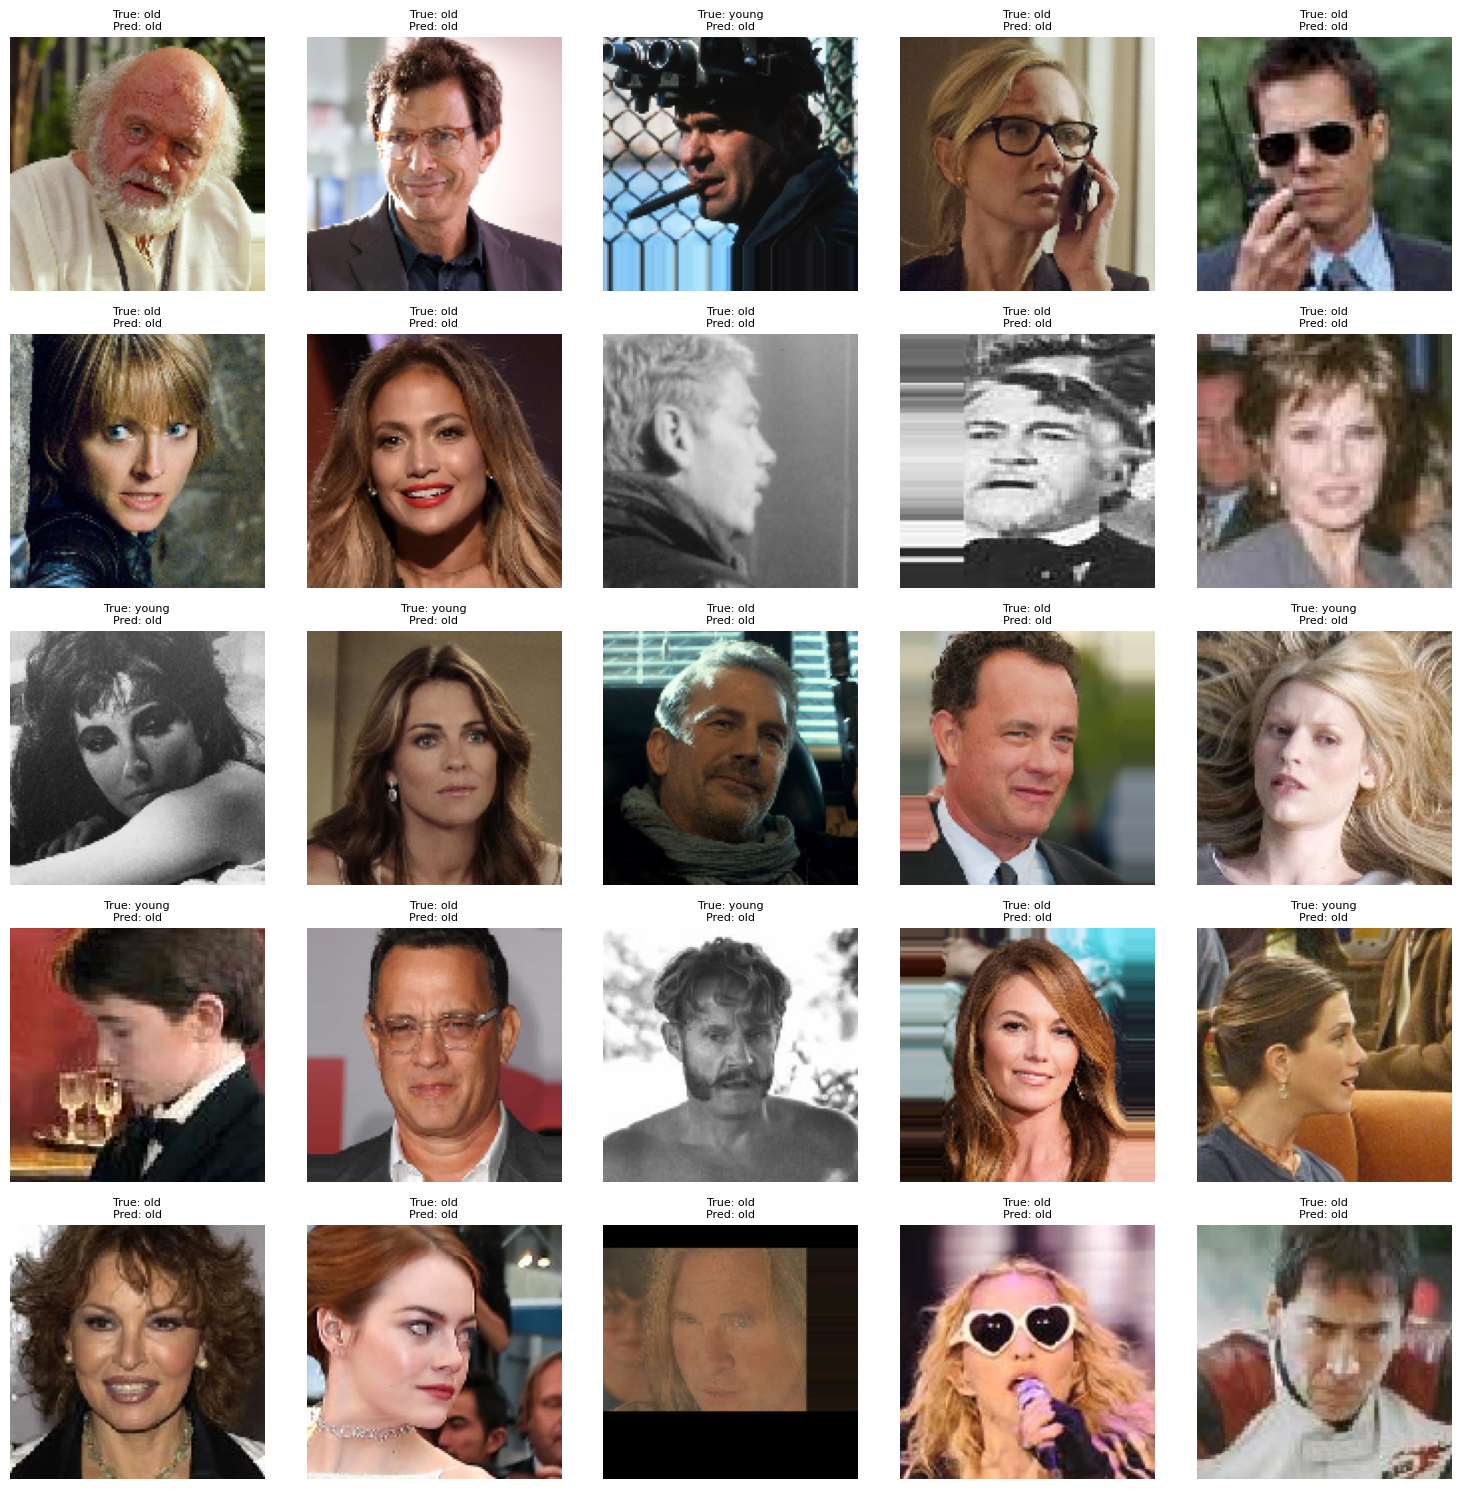

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

images, labels = next(validation_generator)
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)
class_names = list(validation_generator.class_indices.keys())

def plot_images(images, true_labels, pred_labels, class_names, num_images=25):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        true_label = class_names[true_labels[i]]
        pred_label = class_names[pred_labels[i]]
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(images, true_classes, predicted_classes, class_names)


Hier kunnen we ook goed zien dat images niet alleen het gezicht zijn daarbij zien we ook images waar meerdere mensen opstaan, we hebben aan het begin gefilterd op -inf, maar het lijkt erop dat er dus issues in de dataset zijn die ervoor zorgen dat er nog steeds meerdere mensen zijn.

Dit zullen we later fixxen door te kijken naar de face_score

## 3.9 Een beter model maken 

We gaan nu meer lagen toevoegen daarbij gaan we ook gebruik maken van BatchNormalization dit werkt ongeveer alsvolgt: 

- BatchNormalization normaliseert de output van een laag door de activaties te centreren (door het gemiddelde af te trekken) en te schalen (door te delen door de standaardafwijking). Dit helpt om te voorkomen dat activaties te groot of te klein worden, ook zal dit helpen om overfitten te voorkomen 

- MaxPooling2D is een type poolinglaag. Het heeft als doel om de dimensies van de input tensor te verminderen en tegelijkertijd de belangrijkste kenmerken te behouden. Hoe het werkt is het pakt de maximale waarde in het venster pakt dus hier elke 2x2 gebied pak je de hoogste nummer uit 

Verder gebruiken we Dropout om het overfitten op te lossen 

In [35]:
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers import SeparableConv2D, MaxPooling2D
from keras.layers import SpatialDropout2D, Activation, Dropout
from keras.layers import Flatten, Dense, Input
from keras.regularizers import l1_l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)

x = SeparableConv2D(64, (3, 3), padding="same")(inputs)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = SeparableConv2D(128, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = SeparableConv2D(128, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.15)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(256, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.15)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(256, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.15)(x)
x = BatchNormalization()(x)

x = Flatten()(x)

x = Dense(128)(x)
x = Activation("relu")(x)
x = Dropout(0.30)(x)
x = BatchNormalization()(x)

x = Dense(64)(x)
x = Activation("relu")(x)
x = Dropout(0.30)(x)
x = BatchNormalization()(x)

x = Dense(64)(x)
x = Activation("relu")(x)
x = Dropout(0.20)(x)
x = BatchNormalization()(x)

x = Dense(2)(x)
x = Activation("softmax")(x)

age_model = Model(inputs=inputs, outputs=x)
model = age_model

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    destination_folder,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    destination_folder,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50
)



Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 128, 128, 64)   │           283 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 64, 64, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 32, 32, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 16, 16, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 16, 16, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 8, 8, 256)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 8, 8, 256)      │        68,09

 Total params: 670,429 (2.56 MB)

 Trainable params: 668,253 (2.55 MB)

 Non-trainable params: 2,176 (8.50 KB)

Found 40001 images belonging to 2 classes.
Found 9999 images belonging to 2 classes.
Epoch 1/50
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 90s 58ms/step - accuracy: 0.5343 - loss: 0.7858 - val_accuracy: 0.6294 - val_loss: 0.6428
Epoch 2/50
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 61s 48ms/step - accuracy: 0.5974 - loss: 0.6607 - val_accuracy: 0.6448 - val_loss: 0.6212
Epoch 3/50
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 76s 61ms/step - accuracy: 0.6259 - loss: 0.6399 - val_accuracy: 0.6580 - val_loss: 0.6107
Epoch 4/50
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 73s 58ms/step - accuracy: 0.6511 - loss: 0.6198 - val_accuracy: 0.6461 - val_loss: 0.6184
Epoch 5/50
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 81s 65ms/step - accuracy: 0.6661 - loss: 0.6049 - val_accuracy: 0.6854 - val_loss: 0.5812
Epoch 6/50
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 69s 55ms/step - accuracy: 0.6807 - loss: 0.5893 - val_accuracy: 0.6934 - val_loss: 0.5716
Epoch 7/50
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 75s 60ms/step - accuracy: 0.6984 - loss: 0.5712 - val_accuracy: 0.5830 - val_loss

In [36]:
print(train_generator.class_indices)

{'old': 0, 'young': 1}


## 3.9 Resultaten van het model veel overfitten 

We kunnen hier al zien dat we een stuk beter model krijgen met daarbij een accuracy van bijna 0.90, alleen als we dan kijken naar een andere belangrijk onderdeel zien we dat de val_accuracy maar 0.67 oftewel we zijn vol aan het overfitten. In het model hebben we al veel gespeeld met verschillende opties om veel overfitten te voorkomen, maar dit lijkt het niet beter te maken 

We gaan hierdoor niet verder op deze images en zullen daarom nu alleen images pakken die van hoog kwaliteit zijn dus oftewel een high score boven 4 hier zijn 45k images van. Ik denk dat dit daarom erg geschikt is en ook omdat de images hiervan er goed uitzien. 

## 3.9 High score boven 4 alleen meenemen 

We hebben tot nu toe alle foto's toegestaan voor het trainen dit betekent ook waar face_score erg laag is dit is voor het model veel lastiger om op te trainen en patronen goed te vinden, omdat gezihten scheef erop staan. We willen dus alleen kwaliteit foto's hebben hierdoor zouden we waarschijnlijk een beter model moeten kunnen trainen dit gaan we hier doen :

Ik heb meerdere modellen getest ook heb ik gekeken naar het volgende artikel waar ook age voorspellingen worden gedaan hier heb ik inspiratie uit gedaan voor mijn model : 

https://rgnpublications.com/ICACTCE2021/manuscripts/001-5.pdf



## 3.10 Calculate face_score hoger dan 4 

We moeten nu ook een nieuwe folder maken met alleen de high score 4 anders krijgen we issues dat het model nog steeds de oude images pakt en dus niet anders zal gaan trainen 

In [37]:
df_first_50k = df[df['face_score'] >= 4]

df_first_50k['age'] = df_first_50k['photo_taken'] - df_first_50k['dob']

df_first_50k['age_group'] = df_first_50k['age'].apply(lambda x: 'young' if 21 <= x <= 41 else 'old')

df_first_50k['age_group'] = df_first_50k['age_group'].map({'young': 0, 'old': 1})

features = ['photo_taken', 'gender', 'face_score', 'second_face_score']
target = 'age_group'

X = df_first_50k[features]
y = df_first_50k[target]



/tmp/ipykernel_2579/3162359799.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_50k['age'] = df_first_50k['photo_taken'] - df_first_50k['dob']
/tmp/ipykernel_2579/3162359799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_50k['age_group'] = df_first_50k['age'].apply(lambda x: 'young' if 21 <= x <= 41 else 'old')
/tmp/ipykernel_2579/3162359799.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [38]:
df_first_50k

dob  photo_taken                                        full_path  \
12      1925.0         1974    [02/nm0000002_rm221957120_1924-9-16_1974.jpg]   
14      1925.0         1974    [02/nm0000002_rm238734336_1924-9-16_1974.jpg]   
15      1925.0         2006   [02/nm0000002_rm2585828096_1924-9-16_2006.jpg]   
18      1925.0         2006   [02/nm0000002_rm2769394176_1924-9-16_2006.jpg]   
23      1925.0         2007   [02/nm0000002_rm2983566080_1924-9-16_2007.jpg]   
...        ...          ...                                              ...   
460621  1987.0         2010    [19/nm2999419_rm971736576_1986-3-23_2010.jpg]   
460628  1977.0         2012    [67/nm3993767_rm3807950592_1976-9-1_2012.jpg]   
460629  1977.0         2012    [67/nm3993767_rm3841505024_1976-9-1_2012.jpg]   
460676  1991.0         2014    [08/nm3994408_rm28296192_1989-12-29_2014.jpg]   
460682  1991.0         2013  [08/nm3994408_rm2978193408_1989-12-29_2013.jpg]   

        gender                  name  \
12         0.0       [Lauren Bacall]   
14         0.0       [Lauren Bacall]   
15         0.0       [Lauren Bacall]   
18         0.0       [Lauren Bacall]   
23         0.0       [Lauren Bacall]   
...        ...                   ...   
460621     1.0       [Ben Rappaport]   
460628     NaN  [Asa Soltan Rahmati]   
460629     NaN  [Asa Soltan Rahmati]   
460676     0.0           [Jane Levy]   
460682     0.0           [Jane Levy]   

                                            face_location  face_score  \
12      [[3173.144692593433, 401.0408365741791, 4059.1...    4.096431   
14      [[2135.2177839424635, 765.8537799794512, 3499....    4.865421   
15      [[70.08922573752601, 87.46603217190751, 225.89...    5.414545   
18      [[109.42467458662298, 82.24100593996724, 231.0...    4.360469   
23      [[85.53605744346052, 47.748476357478076, 170.0...    4.126855   
...                                                   ...         ...   
460621                      [[282.4, 90.4, 396.8, 204.8]]    4.539457   
460628  [[132.4644002431801, 88.57493349545341, 263.33...    4.548921   
460629  [[173.314, 58.370000000000005, 301.728, 186.784]]    4.686810   
460676  [[372.77560009473257, 465.45750011841574, 1204...    5.775154   
460682  [[372.77560009473257, 558.1394001420989, 1204....    4.241045   

        second_face_score  celeb_id    celeb_names   age  age_group  
12                    NaN     11516  [Aaron Russo]  49.0          1  
14                    NaN     11516  [Aaron Russo]  49.0          1  
15                    NaN     11516  [Aaron Russo]  81.0          1  
18                    NaN     11516  [Aaron Russo]  81.0          1  
23                    NaN     11516  [Aaron Russo]  82.0          1  
...                   ...       ...            ...   ...        ...  
460621                NaN      1883            NaN  23.0          0  
460628                NaN      1505            NaN  35.0          0  
460629                NaN      1505            NaN  35.0          0  
460676                NaN      8410            NaN  23.0          0  
460682                NaN      8410            NaN  22.0          0  

[45739 rows x 12 columns]

Nu we nieuwe afbeeldingen ontvangen, moeten we deze opnieuw organiseren in een map, maar alleen voor afbeeldingen waarvan de face_score hoger is dan 4.

Een alternatief zou zijn om rechtstreeks te filteren op basis van de full_path in de DataFrame en alleen die afbeeldingen te selecteren en te gebruiken. Dit zou het kopiëren van afbeeldingen overbodig maken. Voor nu is het  eenvoudig om de afbeeldingen opnieuw te kopiëren en te organiseren op basis van de face_score.

In [39]:
import os
import shutil
import pandas as pd

source_folder = 'imdb_crop'
destination_folder = 'imdb_categorized_face_score_4_or_more'
young_folder = os.path.join(destination_folder, 'young')
old_folder = os.path.join(destination_folder, 'old')

os.makedirs(young_folder, exist_ok=True)
os.makedirs(old_folder, exist_ok=True)

young_count = 0
old_count = 0

for idx, row in df_first_50k.iterrows():
    full_path = row['full_path'][0]
    age = row['age']
    src_path = os.path.join(source_folder, full_path)

    if age <= 41:
        dest_folder = young_folder
        young_count += 1
    else:
        dest_folder = old_folder
        old_count += 1

    try:
        shutil.copy(src_path, dest_folder)
    except Exception as e:
        print(f"Error moving {src_path}: {e}")

# Print het aantal verplaatste afbeeldingen
print(f"Aantal afbeeldingen in young folder: {young_count}")
print(f"Aantal afbeeldingen in old folder: {old_count}")

Aantal afbeeldingen in young folder: 33513
Aantal afbeeldingen in old folder: 12226


Hieronder zullen we opnieuw gaan testen op het model waarbij we face_score van minimaal 4 hebben. We zullen hetzelfde soort model gebruiken als de vorige aangezien deze een stuk betere prestaties gaf dan het eerste model 

In [47]:
input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)

x = SeparableConv2D(64, (3, 3), padding="same")(inputs)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = SeparableConv2D(128, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = SeparableConv2D(128, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.15)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(256, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.15)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(256, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.15)(x)
x = BatchNormalization()(x)

x = Flatten()(x)

x = Dense(128)(x)
x = Activation("relu")(x)
x = Dropout(0.30)(x)
x = BatchNormalization()(x)

x = Dense(64)(x)
x = Activation("relu")(x)
x = Dropout(0.30)(x)
x = BatchNormalization()(x)

x = Dense(64)(x)
x = Activation("relu")(x)
x = Dropout(0.20)(x)
x = BatchNormalization()(x)

x = Dense(2)(x)
x = Activation("softmax")(x)

age_model = Model(inputs=inputs, outputs=x)
model = age_model

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    destination_folder,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    destination_folder,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)



Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_25             │ (None, 128, 128, 64)   │           283 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_26             │ (None, 64, 64, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_46 (Activation)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_27             │ (None, 32, 32, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_47 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_15            │ (None, 16, 16, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_28             │ (None, 16, 16, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_16            │ (None, 8, 8, 256)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_29             │ (None, 8, 8, 256)      │        68,09

 Total params: 670,429 (2.56 MB)

 Trainable params: 668,253 (2.55 MB)

 Non-trainable params: 2,176 (8.50 KB)

Found 36592 images belonging to 2 classes.
Found 9147 images belonging to 2 classes.
Epoch 1/10
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 57s 44ms/step - accuracy: 0.6622 - loss: 0.6839 - val_accuracy: 0.7377 - val_loss: 0.5568
Epoch 2/10
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.7471 - loss: 0.5495 - val_accuracy: 0.7457 - val_loss: 0.5433
Epoch 3/10
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 57s 49ms/step - accuracy: 0.7675 - loss: 0.5111 - val_accuracy: 0.7524 - val_loss: 0.5268
Epoch 4/10
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 75s 65ms/step - accuracy: 0.7998 - loss: 0.4487 - val_accuracy: 0.5662 - val_loss: 0.7382
Epoch 5/10
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 58s 50ms/step - accuracy: 0.8142 - loss: 0.4233 - val_accuracy: 0.7619 - val_loss: 0.5069
Epoch 6/10
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 58s 50ms/step - accuracy: 0.8358 - loss: 0.3911 - val_accuracy: 0.7811 - val_loss: 0.5048
Epoch 7/10
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 57s 50ms/step - accuracy: 0.8349 - loss: 0.3859 - val_accuracy: 0.7870 - val_loss

We kunnen zien dat het model nog steeds overfit waarbij de acuracy 0.86 is en de val accuracy 0.75. We zien ook dat naar mate de tijd de val_accuracy daalt, dit betekent dat als we meer epochs zouden testen we waarschijnlijk niet een beter resultaten zullen gaan krijgen 

## Evaluation: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


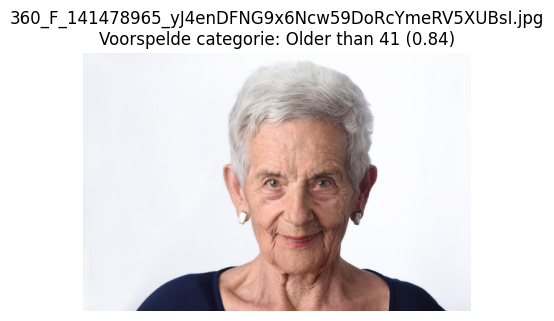

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


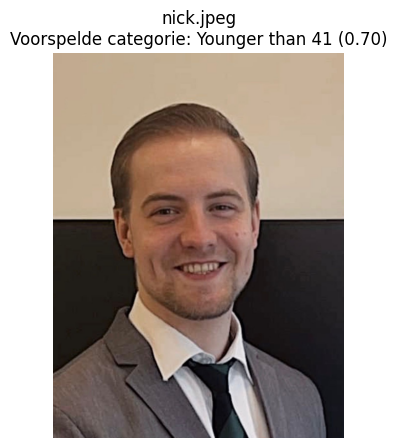

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


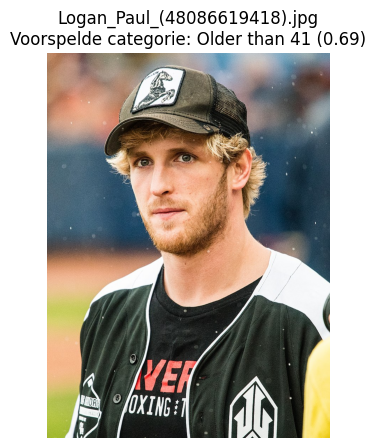

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


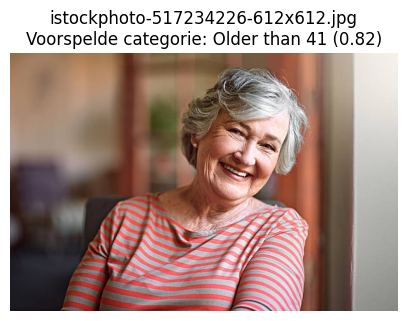

Afbeelding: 360_F_141478965_yJ4enDFNG9x6Ncw59DoRcYmeRV5XUBsI.jpg, Voorspelde categorie: Older than 41, Waarschijnlijkheid: 0.84
Afbeelding: nick.jpeg, Voorspelde categorie: Younger than 41, Waarschijnlijkheid: 0.70
Afbeelding: Logan_Paul_(48086619418).jpg, Voorspelde categorie: Older than 41, Waarschijnlijkheid: 0.69
Afbeelding: istockphoto-517234226-612x612.jpg, Voorspelde categorie: Older than 41, Waarschijnlijkheid: 0.82


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

def load_and_process_image(filepath, target_size=(128, 128)):
    img = image.load_img(filepath, target_size=target_size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img

def predict_images_from_folder(folder_path, model, target_size=(128, 128)):
    results = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.jpeg') or filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)

            processed_image = load_and_process_image(image_path, target_size)

            prediction = model.predict(processed_image)

            predicted_probabilities = prediction[0]

            predicted_class = np.argmax(predicted_probabilities)
            class_names = ["Older than 41", "Younger than 41"]

            predicted_category = class_names[predicted_class]
            predicted_probability = predicted_probabilities[predicted_class]

            results.append({
                'filename': filename,
                'predicted_category': predicted_category,
                'predicted_probability': predicted_probability
            })

            img = image.load_img(image_path)
            plt.figure(figsize=(5, 5))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{filename}\nVoorspelde categorie: {predicted_category} ({predicted_probability:.2f})")
            plt.show()

    return results

folder_path = 'testimagesinmodel'

results = predict_images_from_folder(folder_path, model)

for result in results:
    print(f"Afbeelding: {result['filename']}, Voorspelde categorie: {result['predicted_category']}, Waarschijnlijkheid: {result['predicted_probability']:.2f}")


Kunnen we met dit model betrouwbaar schatten of een beroemdheid oud is?

We krijgen een resultaat van rond de 0.75/0.80 wat een redelijk goed model is. Natuurlijk is het lastig voor het model aangezien sommige mensen toch echt een stuk ouder of jonger lijken dan ze daadwerkelijk zijn. IK heb zelf ook een aantal foto's in het model gestopt om te kijken of hij deze images kan voorspellen hoe oud iemand is ik zie goede resulaten. 

Dit model is betrouwbaar, maar zou meer finetuning kunnen gebruiken tijdens data prep, nog betere images pakken aan de hand van face_score etc